In [3]:
from google.colab import files
uploaded = files.upload()

Saving new_data.csv to new_data.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving f1sim-ref-left.csv to f1sim-ref-left.csv
Saving f1sim-ref-line.csv to f1sim-ref-line.csv
Saving f1sim-ref-right.csv to f1sim-ref-right.csv
Saving f1sim-ref-turns.csv to f1sim-ref-turns.csv


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
df = pd.read_csv("new_data.csv")
df

,lap_id,invalid_lap,BPS_SPEED,BPS_THROTTLE,BPS_STEER,BPS_BRAKE,BPS_LAPDISTANCE,BPS_WORLDPOSITIONX,BPS_WORLDPOSITIONY,BPS_WORLDFORWARDDIRX,...,APX2_YAW,APX2_PITCH,APX2_ROLL,APX2_left_dist,APX2_dist_apex_1,APX2_dist_apex_2,APX2_angle_to_apex1,APX2_angle_to_apex2,APX2_proj_from_ref,Target_CURRENTLAPTIMEINMS
0,10021698834789871149_1,1,316.0,1.000000,0.074568,0.0,223.0,274.071987,313.458779,-23579.0,...,-2.906792,0.002597,-0.015706,1.188303,101.216786,1.468423,176.387023,-73.297876,1.243211,15377
1,10021698834789871149_10,1,324.0,0.970802,0.000464,0.0,273.0,310.096901,278.846172,-23824.0,...,-2.975512,-0.004548,-0.010439,1.716472,101.368594,0.941933,178.312192,-68.980181,0.715854,12146
2,10021698834789871149_11,1,322.0,1.000000,-0.002375,0.0,258.0,298.743940,288.688005,-23746.0,...,-2.922204,-0.003019,-0.011373,2.731520,101.668646,0.122973,176.987177,53.851467,0.297512,12220
3,10021698834789871149_12,0,322.0,0.025177,0.006011,0.0,269.0,307.165908,281.569461,-23818.0,...,-2.923212,-0.002735,-0.009557,1.879479,101.417020,0.779785,177.377583,-68.683995,0.553155,12219
4,10021698834789871149_13,1,324.0,1.000000,0.021114,0.0,268.0,306.397540,282.215448,-23831.0,...,-2.824224,0.006822,-0.014098,4.818916,102.315233,2.167787,173.829692,99.915419,2.381417,12881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,9874269645241895165_2,1,144.0,0.000000,-0.525250,0.0,450.0,369.369267,134.915112,5165.0,...,-2.974651,-0.000140,-0.022406,2.409240,105.101572,7.066486,179.753790,-120.396863,5.033546,13686
821,9941972541231747669_1,1,324.0,1.000000,0.000000,0.0,263.0,302.615240,285.497492,-23572.0,...,-2.875317,-0.000517,-0.010140,1.617995,101.340908,1.039864,176.906931,-71.039304,0.814210,12490
822,9941972541231747669_2,0,324.0,1.000000,-0.000000,0.0,264.0,303.184481,284.646456,-23649.0,...,-2.914761,-0.002244,-0.008611,1.437935,101.289007,1.219306,177.457928,-71.360891,0.993987,12326
823,9948558370850722411_1,1,324.0,1.000000,-0.003344,0.0,276.0,301.987594,286.287858,-24030.0,...,-2.907833,0.001437,-0.014618,2.980371,101.744896,0.340118,175.711551,87.320007,0.545892,13604


In [6]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import lightgbm

TARGET = "Target_CURRENTLAPTIMEINMS"
PREDICTORS = [
    'Target_CURRENTLAPTIMEINMS',
    'BPS_LAPDISTANCE',
    'BPS_WORLDPOSITIONX',
    'BPS_WORLDPOSITIONY',
    'BPS_STEER',
    'BPS_BRAKE',
    'BPS_THROTTLE',
    'BPS_SPEED',
]

y = df[TARGET]
# log-transform target (stabilize variance)
y_log = np.log1p(y)
X = df[PREDICTORS].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

lgbm = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=-1,          # -1 = no limit; trees will be limited by other params
    num_leaves=63,         # typical start (roughly 2^(max_depth)); tune later
    subsample=0.8,         # bagging_fraction in native LightGBM
    colsample_bytree=0.8,  # feature_fraction
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# Early stopping on a validation set (works with scikit API)
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[lightgbm.log_evaluation(0)]  # Corrected alias
)

# Predict (invert log) & metrics
y_pred_log = lgbm.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Test metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Train metrics
train_pred_log = lgbm.predict(X_train)
train_pred = np.expm1(train_pred_log)
train_true = np.expm1(y_train)
train_rmse = np.sqrt(mean_squared_error(train_true, train_pred))

print(f"Train RMSE: {train_rmse:.3f} ms")
print(f"Test RMSE:  {rmse:.3f} ms")
print(f"Test R²:    {r2:.3f}")

# Pretty print a single row of predictors + prediction
i = 0  # choose which test example to display
sample = X_test.iloc[i]
pred_value = y_pred[i]

print(f"BPS_LAPDISTANCE: {sample['BPS_LAPDISTANCE']:.2f}")
print(f"BPS_CURRENTLAPTIMEINMS: {np.expm1(y_test.iloc[i]):,.2f}")
print(f"BPS_WORLDPOSITIONX: {sample['BPS_WORLDPOSITIONX']:.4f}")
print(f"BPS_WORLDPOSITIONY: {sample['BPS_WORLDPOSITIONY']:.4f}")
print(f"Predicted {TARGET}: {pred_value:,.3f}")

Train RMSE: 776.535 ms
Test RMSE:  1301.304 ms
Test R²:    0.929
BPS_LAPDISTANCE: 275.00
BPS_CURRENTLAPTIMEINMS: 12,272.00
BPS_WORLDPOSITIONX: 311.6848
BPS_WORLDPOSITIONY: 277.6099
Predicted Target_CURRENTLAPTIMEINMS: 12,171.469


In [7]:
# --- 1) Monte-Carlo search for best setup (works with LGBM) ---
import numpy as np
import pandas as pd

def suggest_best_setup_for_log_model_lgbm(
    model,
    X_train: pd.DataFrame,
    percentiles=(0.05, 0.95),
    N=50_000,
    top_k=5,
    seed=42,
    hard_bounds: dict | None = None,   # e.g. {"BPS_THROTTLE": (0,1)}
    int_cols: list[str] | None = None, # e.g. ["gear"]
):
    rng = np.random.default_rng(seed)

    # numeric columns only
    num_cols = X_train.select_dtypes(include=["number"]).columns
    q = X_train[num_cols].quantile([percentiles[0], percentiles[1]])
    low, high = q.loc[percentiles[0]], q.loc[percentiles[1]]

    # sample candidates
    candidates = {c: rng.uniform(low=low[c], high=high[c], size=N) for c in num_cols}
    Xcand = pd.DataFrame(candidates)[num_cols]

    # enforce hard bounds
    if hard_bounds:
        for c, (lo, hi) in hard_bounds.items():
            if c in Xcand.columns:
                Xcand[c] = np.clip(Xcand[c], lo, hi)

    # cast integer cols
    if int_cols:
        for c in int_cols:
            if c in Xcand.columns:
                Xcand[c] = Xcand[c].round().astype(int)

    # predict in log space then invert
    ypred_ms = np.expm1(model.predict(Xcand))

    # best candidates
    order = np.argsort(ypred_ms)
    best_idx = order[:top_k]

    topk = Xcand.iloc[best_idx].copy()
    topk["Predicted_Target_CURRENTLAPTIMEINMS"] = ypred_ms[best_idx]

    best_setup = topk.iloc[0].drop("Predicted_Target_CURRENTLAPTIMEINMS")
    best_pred  = float(topk.iloc[0]["Predicted_Target_CURRENTLAPTIMEINMS"])
    return topk.reset_index(drop=True), best_setup, best_pred

# ---- run it on your trained LightGBM model ----
topk, best_setup, best_pred = suggest_best_setup_for_log_model_lgbm(
    model=lgbm,
    X_train=X_train,
    percentiles=(0.05, 0.95),
    N=50_000,
    top_k=5,
    seed=42,
    hard_bounds={
        # "BPS_THROTTLE": (0.0, 1.0),
        # "BPS_BRAKE":    (0.0, 1.0),
        # "BPS_STEER":    (-1.0, 1.0),
        # "BPS_SPEED":    (0.0, None),  # None → skip clip
    },
    int_cols=[
        # "gear",
    ],
)

print("\n=== Suggested optimal setup (within 5–95% train ranges) ===")
for k, v in best_setup.items():
    print(f"{k}: {v:.4f}")
print(f"Predicted Target_CURRENTLAPTIMEINMS: {best_pred:,.3f} ms")

print("\nTop-5 suggested setups:")
print(topk.to_string(index=False))



=== Suggested optimal setup (within 5–95% train ranges) ===
Target_CURRENTLAPTIMEINMS: 12444.9464
BPS_LAPDISTANCE: 278.4381
BPS_WORLDPOSITIONX: 331.0538
BPS_WORLDPOSITIONY: 271.7105
BPS_STEER: 0.0308
BPS_BRAKE: 0.0000
BPS_THROTTLE: 0.7624
BPS_SPEED: 292.9042
Predicted Target_CURRENTLAPTIMEINMS: 12,009.554 ms

Top-5 suggested setups:
 Target_CURRENTLAPTIMEINMS  BPS_LAPDISTANCE  BPS_WORLDPOSITIONX  BPS_WORLDPOSITIONY  BPS_STEER  BPS_BRAKE  BPS_THROTTLE  BPS_SPEED  Predicted_Target_CURRENTLAPTIMEINMS
              12444.946411       278.438053          331.053784          271.710535   0.030806        0.0      0.762384 292.904157                         12009.554063
              12442.645955       285.391726          332.306984          253.166376   0.033350        0.0      0.764238 277.028111                         12051.588308
              12375.391075       256.847604          323.995457          274.948171   0.015898        0.0      0.346654 283.870212                         12136

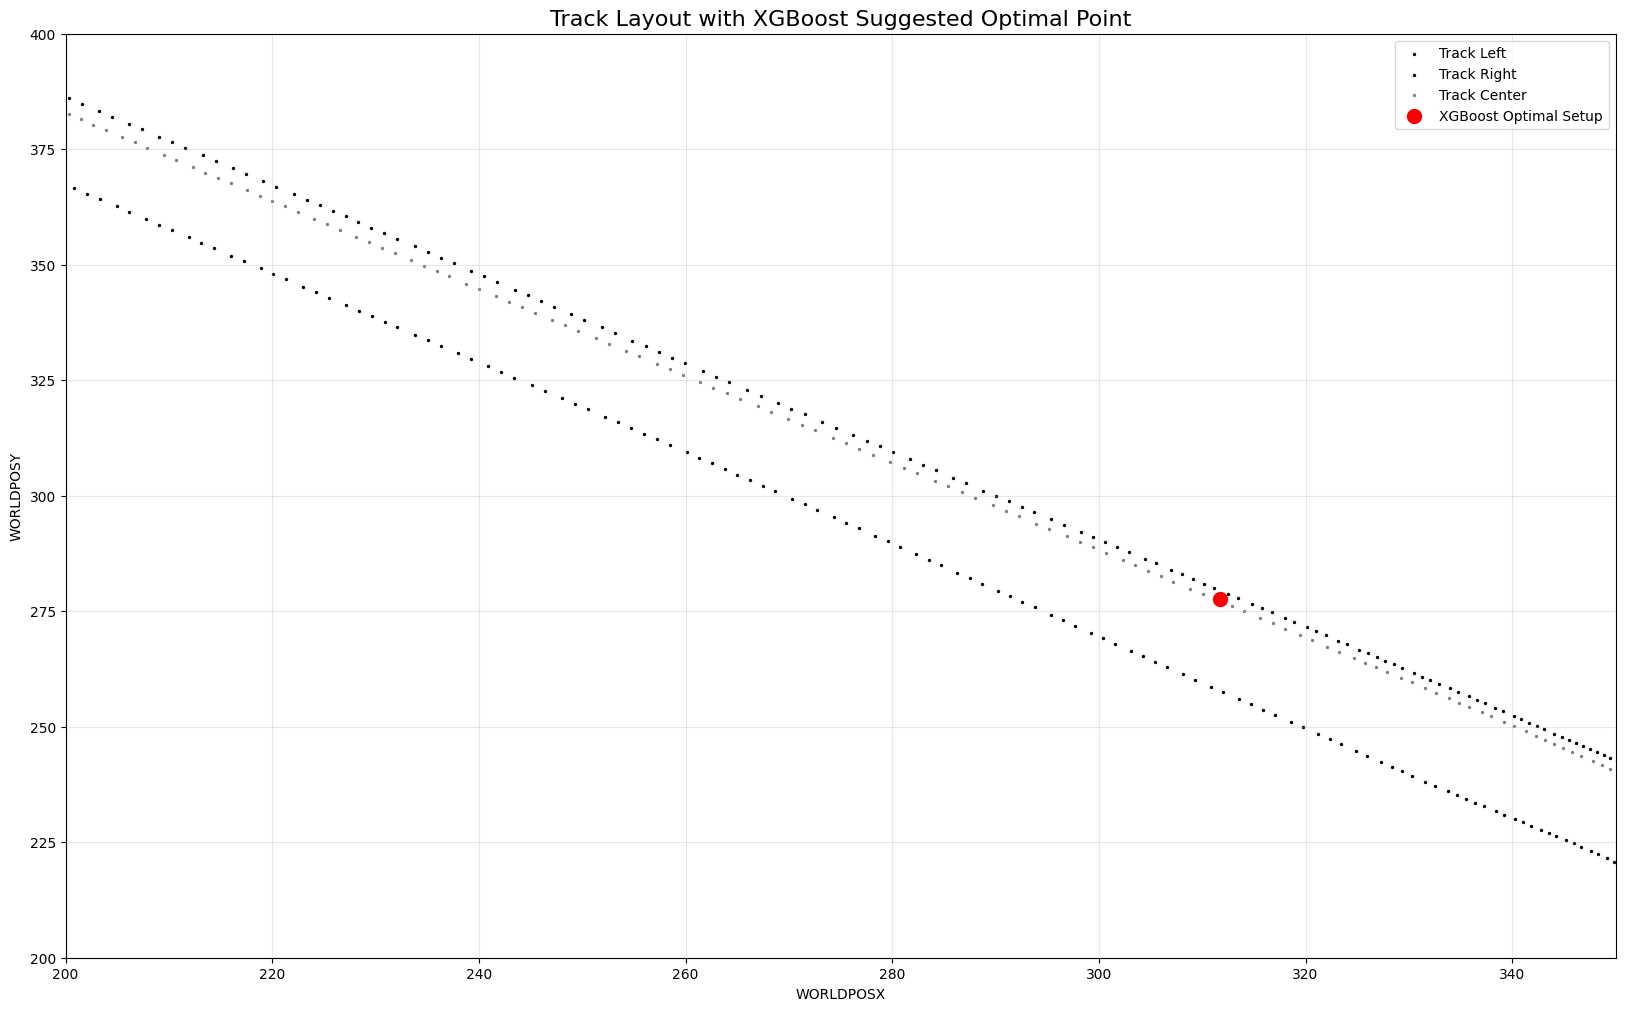

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

track_left  = pd.read_csv("f1sim-ref-left.csv")
track_right = pd.read_csv("f1sim-ref-right.csv")
track_line  = pd.read_csv("f1sim-ref-line.csv")
turns       = pd.read_csv("f1sim-ref-turns.csv")

f = 100000

plt.figure(figsize=(20, 12))

# Draw track boundaries
plt.scatter(track_left[track_left["FRAME"] <= f]["WORLDPOSX"],
            track_left[track_left["FRAME"] <= f]["WORLDPOSY"],
            s=2, color="black", label="Track Left")
plt.scatter(track_right[track_right["FRAME"] <= f]["WORLDPOSX"],
            track_right[track_right["FRAME"] <= f]["WORLDPOSY"],
            s=2, color="black", label="Track Right")
plt.scatter(track_line[track_line["FRAME"] <= f]["WORLDPOSX"],
            track_line[track_line["FRAME"] <= f]["WORLDPOSY"],
            s=2, color="gray", label="Track Center")

# Plots the suggested optimal setup point from the model

plt.scatter(311.6848, 277.6099, color="red", s=100, label="XGBoost Optimal Setup")

# Annotation of turns
for _, row in turns.iterrows():
    plt.annotate(str(row["TURN"]),
                 (row["APEX_X1"], row["APEX_Y1"]),
                 textcoords="offset points", xytext=(5, 5),
                 color="black", fontsize=10, weight="bold")

# Set zoomed-in limits
plt.xlim(200, 350)
plt.ylim(200, 400)

plt.xlabel("WORLDPOSX")
plt.ylabel("WORLDPOSY")
plt.title("Track Layout with XGBoost Suggested Optimal Point", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import lightgbm

TARGET = "Target_CURRENTLAPTIMEINMS"
PREDICTORS = [
    'Target_CURRENTLAPTIMEINMS',
    'BPE_LAPDISTANCE',
    'BPE_WORLDPOSITIONX',
    'BPE_WORLDPOSITIONY',
    'BPE_STEER',
    'BPE_BRAKE',
    'BPE_THROTTLE',
    'BPE_SPEED',
]

y = df[TARGET]
# log-transform target (stabilize variance)
y_log = np.log1p(y)
X = df[PREDICTORS].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

lgbm = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=-1,          # -1 = no limit; trees will be limited by other params
    num_leaves=63,         # typical start (roughly 2^(max_depth)); tune later
    subsample=0.8,         # bagging_fraction in native LightGBM
    colsample_bytree=0.8,  # feature_fraction
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# Early stopping on a validation set (works with scikit API)
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[lightgbm.log_evaluation(0)]  # Corrected alias
)

# Predict (invert log) & metrics
y_pred_log = lgbm.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Test metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Train metrics
train_pred_log = lgbm.predict(X_train)
train_pred = np.expm1(train_pred_log)
train_true = np.expm1(y_train)
train_rmse = np.sqrt(mean_squared_error(train_true, train_pred))

print(f"Train RMSE: {train_rmse:.3f} ms")
print(f"Test RMSE:  {rmse:.3f} ms")
print(f"Test R²:    {r2:.3f}")

# Pretty print a single row of predictors + prediction
i = 0  # choose which test example to display
sample = X_test.iloc[i]
pred_value = y_pred[i]

print(f"BPE_LAPDISTANCE: {sample['BPE_LAPDISTANCE']:.2f}")
print(f"BPE_CURRENTLAPTIMEINMS: {np.expm1(y_test.iloc[i]):,.2f}")
print(f"BPE_WORLDPOSITIONX: {sample['BPE_WORLDPOSITIONX']:.4f}")
print(f"BPE_WORLDPOSITIONY: {sample['BPE_WORLDPOSITIONY']:.4f}")
print(f"Predicted {TARGET}: {pred_value:,.3f}")

Train RMSE: 653.868 ms
Test RMSE:  1386.028 ms
Test R²:    0.920
BPE_LAPDISTANCE: 354.00
BPE_CURRENTLAPTIMEINMS: 12,272.00
BPE_WORLDPOSITIONX: 365.9415
BPE_WORLDPOSITIONY: 220.0245
Predicted Target_CURRENTLAPTIMEINMS: 12,306.400


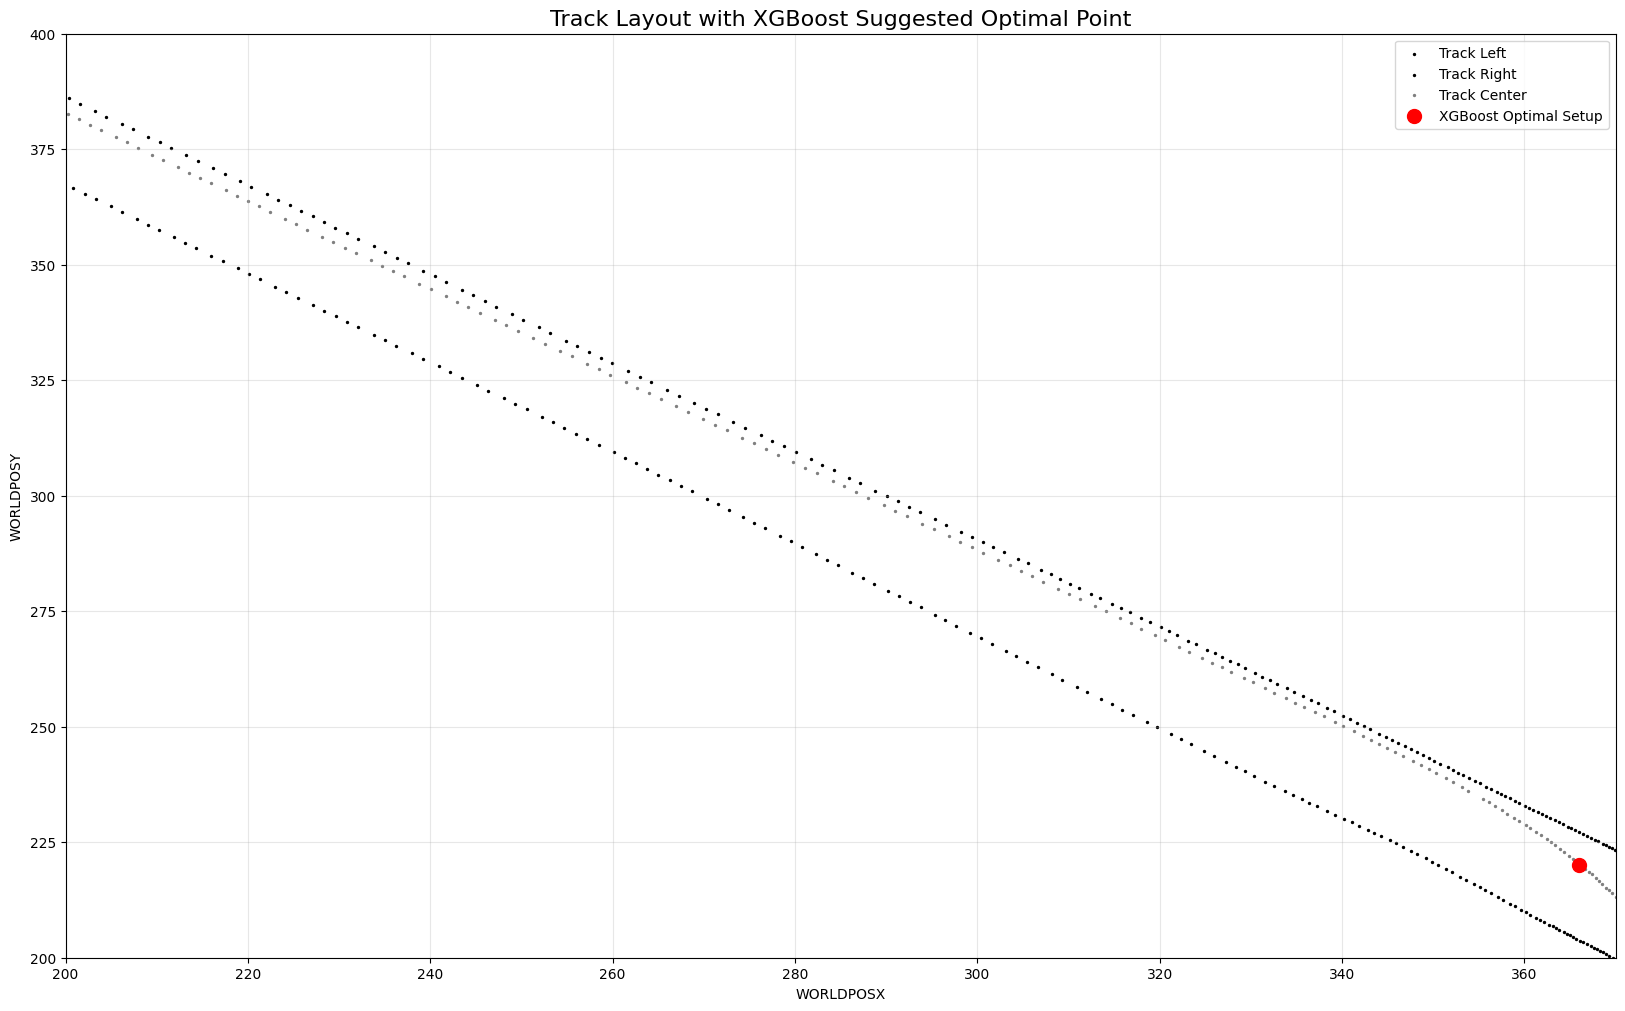

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

track_left  = pd.read_csv("f1sim-ref-left.csv")
track_right = pd.read_csv("f1sim-ref-right.csv")
track_line  = pd.read_csv("f1sim-ref-line.csv")
turns       = pd.read_csv("f1sim-ref-turns.csv")

f = 100000

plt.figure(figsize=(20, 12))

# Draw track boundaries
plt.scatter(track_left[track_left["FRAME"] <= f]["WORLDPOSX"],
            track_left[track_left["FRAME"] <= f]["WORLDPOSY"],
            s=2, color="black", label="Track Left")
plt.scatter(track_right[track_right["FRAME"] <= f]["WORLDPOSX"],
            track_right[track_right["FRAME"] <= f]["WORLDPOSY"],
            s=2, color="black", label="Track Right")
plt.scatter(track_line[track_line["FRAME"] <= f]["WORLDPOSX"],
            track_line[track_line["FRAME"] <= f]["WORLDPOSY"],
            s=2, color="gray", label="Track Center")

# Plots the suggested optimal setup point from the model

plt.scatter(365.9415, 220.0245, color="red", s=100, label="XGBoost Optimal Setup")

# Annotation of turns
for _, row in turns.iterrows():
    plt.annotate(str(row["TURN"]),
                 (row["APEX_X1"], row["APEX_Y1"]),
                 textcoords="offset points", xytext=(5, 5),
                 color="black", fontsize=10, weight="bold")

# Set zoomed-in limits
plt.xlim(200, 370)
plt.ylim(200, 400)

plt.xlabel("WORLDPOSX")
plt.ylabel("WORLDPOSY")
plt.title("Track Layout with XGBoost Suggested Optimal Point", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()